In [8]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

In [106]:
df_maint = pd.read_csv('/Users/dorianfitton/Documents/Cours_Télécom/fil_rouge/fil_rouge.nosync/examples/datasets/maintenance.csv', index_col=['date'])
df_elec = pd.read_csv('/Users/dorianfitton/Documents/Cours_Télécom/fil_rouge/fil_rouge.nosync/examples/datasets/EPEX_FR 2.csv', index_col = ['Date'])

In [107]:
df_maint.index = pd.to_datetime(df_maint.index)
df_elec.index = pd.to_datetime(df_elec.index)

In [108]:
df_all = pd.merge(df_elec, df_maint, left_index=True, right_index=True, how='outer')

In [97]:
df_all=(df_all-df_all.mean())/df_all.std()
df_all_wna = df_all.dropna()

In [98]:
df_all_wna

,Load forecast,Generation forecast,Price,reacteurs_off
2017-01-01 00:00:00+00:00,1.767458,1.003979,-0.303710,0.530933
2017-01-01 01:00:00+00:00,1.657339,0.817276,-0.360274,0.530933
2017-01-01 02:00:00+00:00,1.352397,0.647749,-0.402427,0.530933
2017-01-01 03:00:00+00:00,1.110984,0.573948,-0.418460,0.530933
2017-01-01 04:00:00+00:00,1.034748,0.573517,-0.427377,0.530933
...,...,...,...,...
2022-12-31 19:00:00+00:00,-0.494201,-1.144535,-0.759735,-0.587204
2022-12-31 20:00:00+00:00,-0.714438,-1.214193,-0.794953,-0.587204
2022-12-31 21:00:00+00:00,-0.748320,-1.150577,-0.811256,-0.587204
2022-12-31 22:00:00+00:00,-0.468789,-1.102499,-0.827288,-0.587204


In [99]:
#pd.Series(df_price.index).dt.year

<AxesSubplot:>

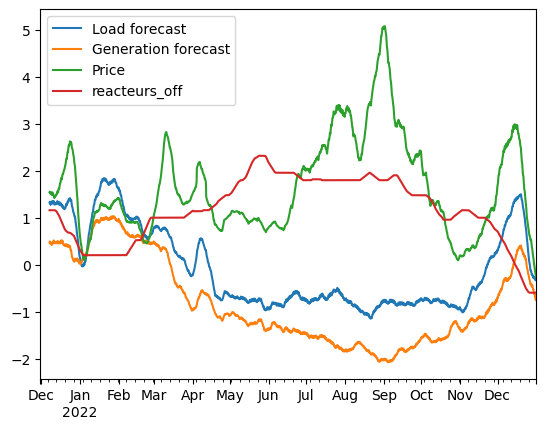

In [100]:
df_all.loc['2021-11-30 00':'2022-12-31 23'].rolling(180).mean().plot()

In [101]:
lag = np.arange(1, 14, 1)

In [118]:
corr = []
for l in lag:
    cor = pd.DataFrame(df_all['Price']).corrwith(pd.DataFrame(df_all['reacteurs_off']), axis=0, lag=l)
    corr.append(corr)

TypeError: DataFrame.corrwith() got an unexpected keyword argument 'lag'

In [46]:
#test de stationnarité

In [129]:
test = adfuller(df_all_wna['Price'].loc['2021-06-30 00':'2022-12-01 23'])
print(f'Test Stat: {test[0]}')
print(f'p-value: {test[1]}')

Test Stat: -5.169751624679769
p-value: 1.0132265280562764e-05


In [39]:
test = adfuller(df_all_wna['Load forecast'].loc['2022-11-30 00':'2022-12-31 23'])
print(f'Test Stat: {test[0]}')
print(f'p-value: {test[1]}')

Test Stat: 0.5111851517390608
p-value: 0.9852091241852475


In [50]:
test = adfuller(df_all_wna['Generation forecast'])
print(f'Test Stat: {test[0]}')
print(f'p-value: {test[1]}')

Test Stat: -6.51302959498947
p-value: 1.0884262717601328e-08


In [51]:
test = adfuller(df_all_wna['reacteurs_off'])
print(f'Test Stat: {test[0]}')
print(f'p-value: {test[1]}')

Test Stat: -1.6544560430629947
p-value: 0.4547175146748701


La variable réacteurs off n'est pas stationnaire, il faut donc la rendre stationnaire pour pouvoir faire un granger causality test dessus.
Pour ce faire, on va transformer la time-series en enlevant la tendance, la variance et la saisonnalité.

In [60]:
# Pour supprimer un maximum de variance, on peut appliquer un logarithme
df_all_wna['reacteurs_off']=np.log(df_all_wna['reacteurs_off'].values)

/var/folders/h9/3f0fc1qs2t3943x127_ynxmc0000gn/T/ipykernel_47143/67264776.py:2: RuntimeWarning: invalid value encountered in log
  df_all_wna['reacteurs_off']=np.log(df_all_wna['reacteurs_off'].values)
/var/folders/h9/3f0fc1qs2t3943x127_ynxmc0000gn/T/ipykernel_47143/67264776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_wna['reacteurs_off']=np.log(df_all_wna['reacteurs_off'].values)


<AxesSubplot:>

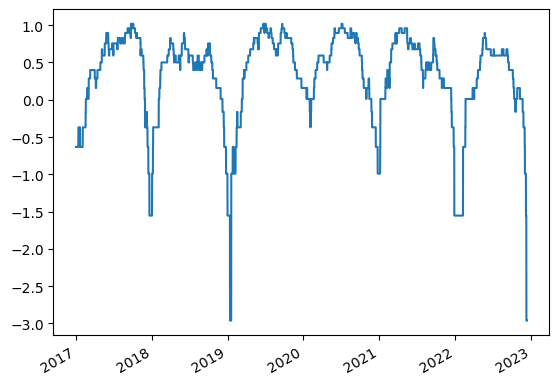

In [63]:
df_all_wna['reacteurs_off'].plot()

Pour enlever la saisonnalité, il faut soustraire les valeurs n+1 avec les valeurs n (si saisonnalité de un an, soustraire les valeurs de January 2021 aux valeurs de january 2022)

In [17]:
#Garnger's test p-value to say if correlated variables are dependent

In [30]:
cor = df_all.corr()
cor

,Load forecast,Generation forecast,Price,reacteurs_off
Load forecast,1.000000,0.860638,0.067721,-0.591232
Generation forecast,0.860638,1.000000,-0.275056,-0.488558
Price,0.067721,-0.275056,1.000000,-0.198475
reacteurs_off,-0.591232,-0.488558,-0.198475,1.000000


In [69]:
grangercausalitytests(df_all_wna[['Generation forecast', 'Price' ]], maxlag=14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=66.3993 , p=0.0000  , df_denom=52388, df_num=1
ssr based chi2 test:   chi2=66.4031 , p=0.0000  , df=1
likelihood ratio test: chi2=66.3611 , p=0.0000  , df=1
parameter F test:         F=66.3993 , p=0.0000  , df_denom=52388, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=372.3161, p=0.0000  , df_denom=52385, df_num=2
ssr based chi2 test:   chi2=744.7033, p=0.0000  , df=2
likelihood ratio test: chi2=739.4601, p=0.0000  , df=2
parameter F test:         F=372.3161, p=0.0000  , df_denom=52385, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=182.3575, p=0.0000  , df_denom=52382, df_num=3
ssr based chi2 test:   chi2=547.1456, p=0.0000  , df=3
likelihood ratio test: chi2=544.3082, p=0.0000  , df=3
parameter F test:         F=182.3575, p=0.0000  , df_denom=52382, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=146.3536

{1: ({'ssr_ftest': (66.39932900584239, 3.762868194472967e-16, 52388.0, 1),
   'ssr_chi2test': (66.40313136491349, 3.6751783515255643e-16, 1),
   'lrtest': (66.3610854637518, 3.7544147565047964e-16, 1),
   'params_ftest': (66.39932900580722, 3.7628681945393813e-16, 52388.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (372.3161065482776, 2.7772057425342784e-161, 52385.0, 2),
   'ssr_chi2test': (744.7032861339798, 1.9486600802323245e-162, 2),
   'lrtest': (739.4600819933112, 2.6809172016282882e-161, 2),
   'params_ftest': (372.316106548437, 2.7772057421001472e-161, 52385.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (182.35749064663406, 1.2310731187153912e-117, 52382.0, 3),
   'ssr_chi2test': (547.1455792535515, 2.8882192358302483e-118, 3),
   'lrtest': (544.3081506477902, 1.1902687619897018e-117, 3),
   'params_ftest': (182.35749064663324,
    1.2310731187153912e-117,
    52382.0,
    3.0)},
   array([[0., 0., 0., 1., 0., 0., 0

In [39]:
grangercausalitytests(df_all_wna[['Load forecast', 'Price']], maxlag=14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.4585 , p=0.0000  , df_denom=52388, df_num=1
ssr based chi2 test:   chi2=23.4599 , p=0.0000  , df=1
likelihood ratio test: chi2=23.4546 , p=0.0000  , df=1
parameter F test:         F=23.4585 , p=0.0000  , df_denom=52388, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=661.0659, p=0.0000  , df_denom=52385, df_num=2
ssr based chi2 test:   chi2=1322.2581, p=0.0000  , df=2
likelihood ratio test: chi2=1305.8476, p=0.0000  , df=2
parameter F test:         F=661.0659, p=0.0000  , df_denom=52385, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=390.5317, p=0.0000  , df_denom=52382, df_num=3
ssr based chi2 test:   chi2=1171.7517, p=0.0000  , df=3
likelihood ratio test: chi2=1158.8399, p=0.0000  , df=3
parameter F test:         F=390.5317, p=0.0000  , df_denom=52382, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=380.

{1: ({'ssr_ftest': (23.458525263508903, 1.279995782075816e-06, 52388.0, 1),
   'ssr_chi2test': (23.459868616486506, 1.2754676645053353e-06, 1),
   'lrtest': (23.454617703246186, 1.2789536929547972e-06, 1),
   'params_ftest': (23.458525263546832, 1.2799957820528377e-06, 52388.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (661.0659491820106, 2.923248590838784e-284, 52385.0, 2),
   'ssr_chi2test': (1322.2580921120755, 7.504183959389506e-288, 2),
   'lrtest': (1305.8475693221553, 2.746649346180886e-284, 2),
   'params_ftest': (661.0659491819495, 2.9232485910129275e-284, 52385.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (390.5317021756398, 6.708600502243046e-251, 52382.0, 3),
   'ssr_chi2test': (1171.751671105318, 9.864737994265933e-254, 3),
   'lrtest': (1158.839927615627, 6.243571406529895e-251, 3),
   'params_ftest': (390.5317021756013, 6.7086005026213345e-251, 52382.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
        

In [44]:
grangercausalitytests(df_all_wna[['reacteurs_off', 'Price']], maxlag=14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4968  , p=0.0191  , df_denom=52388, df_num=1
ssr based chi2 test:   chi2=5.4971  , p=0.0190  , df=1
likelihood ratio test: chi2=5.4968  , p=0.0191  , df=1
parameter F test:         F=5.4968  , p=0.0191  , df_denom=52388, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1544  , p=0.0427  , df_denom=52385, df_num=2
ssr based chi2 test:   chi2=6.3094  , p=0.0427  , df=2
likelihood ratio test: chi2=6.3090  , p=0.0427  , df=2
parameter F test:         F=3.1544  , p=0.0427  , df_denom=52385, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2335  , p=0.0821  , df_denom=52382, df_num=3
ssr based chi2 test:   chi2=6.7014  , p=0.0820  , df=3
likelihood ratio test: chi2=6.7010  , p=0.0821  , df=3
parameter F test:         F=2.2335  , p=0.0821  , df_denom=52382, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.3914  

{1: ({'ssr_ftest': (5.496815362606622, 0.019054852023267354, 52388.0, 1),
   'ssr_chi2test': (5.497130137862173, 0.01904770915607436, 1),
   'lrtest': (5.496841763146222, 0.019050850746754798, 1),
   'params_ftest': (5.4968153611780926, 0.019054852038807475, 52388.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.1544069147671303, 0.042671800585942485, 52385.0, 2),
   'ssr_chi2test': (6.309415987960293, 0.042650853480432016, 2),
   'lrtest': (6.3090360900969245, 0.04265895573396888, 2),
   'params_ftest': (3.154406914125082, 0.04267180061330906, 52385.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.2335064413315853, 0.08209445293292297, 52382.0, 3),
   'ssr_chi2test': (6.701414739123386, 0.08204881990605414, 3),
   'lrtest': (6.70098616881296, 0.08206433881778694, 3),
   'params_ftest': (2.2335064425782067, 0.08209445279768292, 52382.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
  

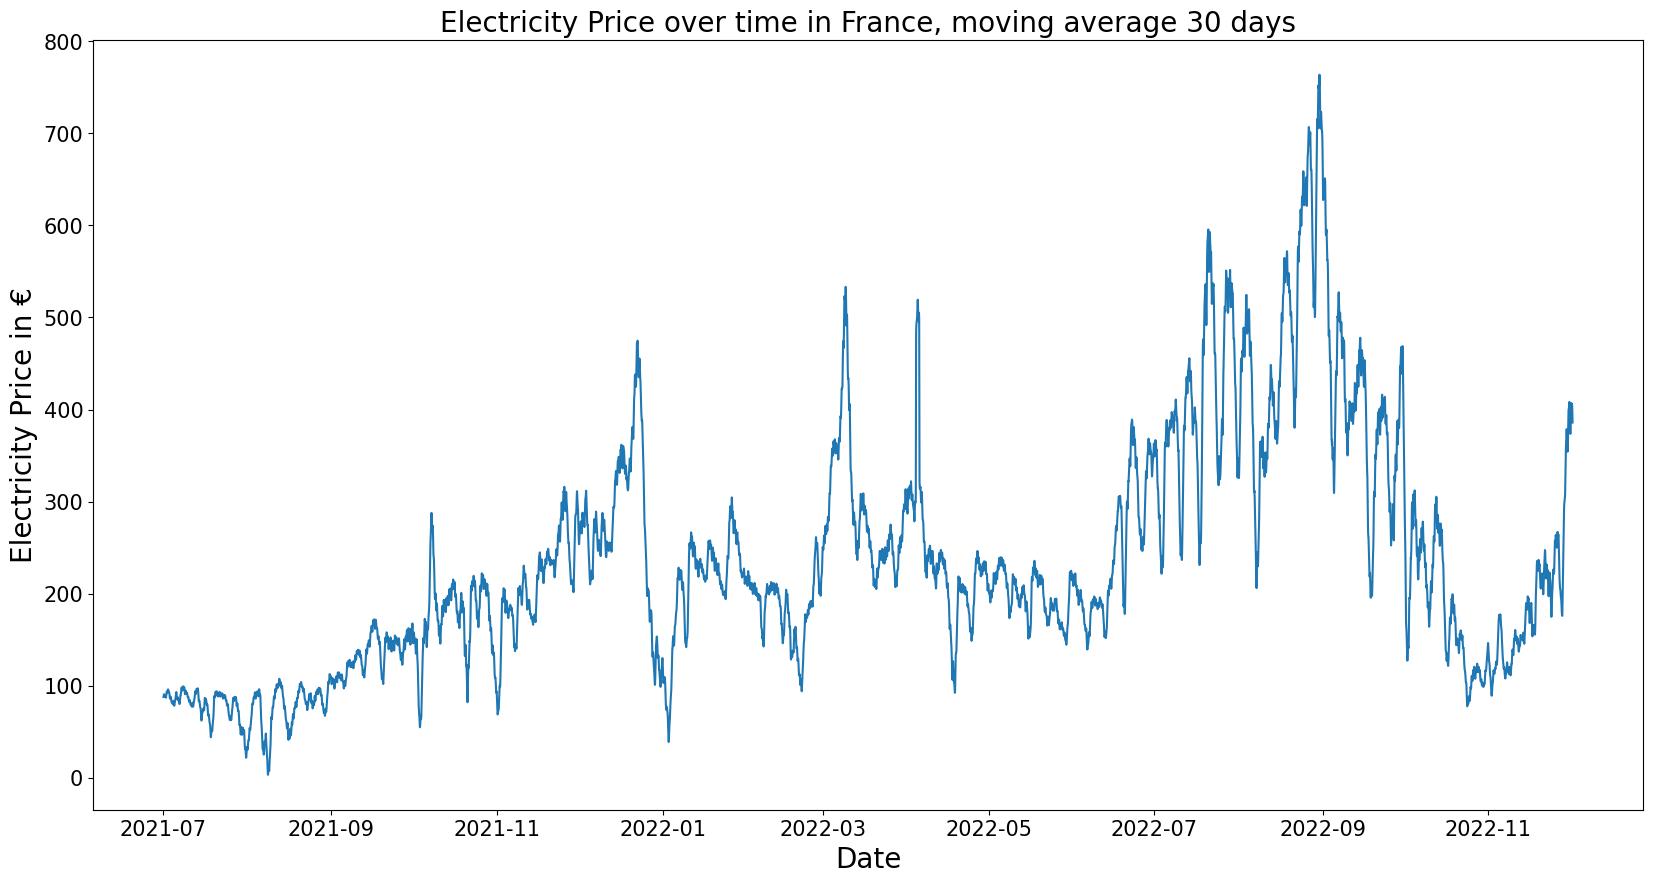

In [127]:
import seaborn as sns
import pandas as pd

# Generate some time-series data
#dates = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
#data = pd.DataFrame(data={'Date': dates, 'Value': range(len(dates))})
df=df_elec.loc['2021-06-30 00':'2022-12-01 23'].rolling(30).mean()#.diff().diff(24)
# Plot the data
plt.figure(figsize=(20,10))
sns.lineplot(x=df.index, y='Price', data=df)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Electricity Price in €', fontsize=20)
plt.title('Electricity Price over time in France, moving average 30 days', fontsize=20)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)

#plt.savefig('/Users/dorianfitton/Documents/Cours_Télécom/fil_rouge/fil_rouge.nosync/Rapport/images/EP_MA_30.png')
plt.show()

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [79]:
result = seasonal_decompose(df['Price'].dropna()+abs(df['Price'].min())+1, model ='multipicative')
seasonality = result.seasonal

In [84]:
seasonality_ = seasonality.loc['2020-04-28 00':'2020-04-30 23']

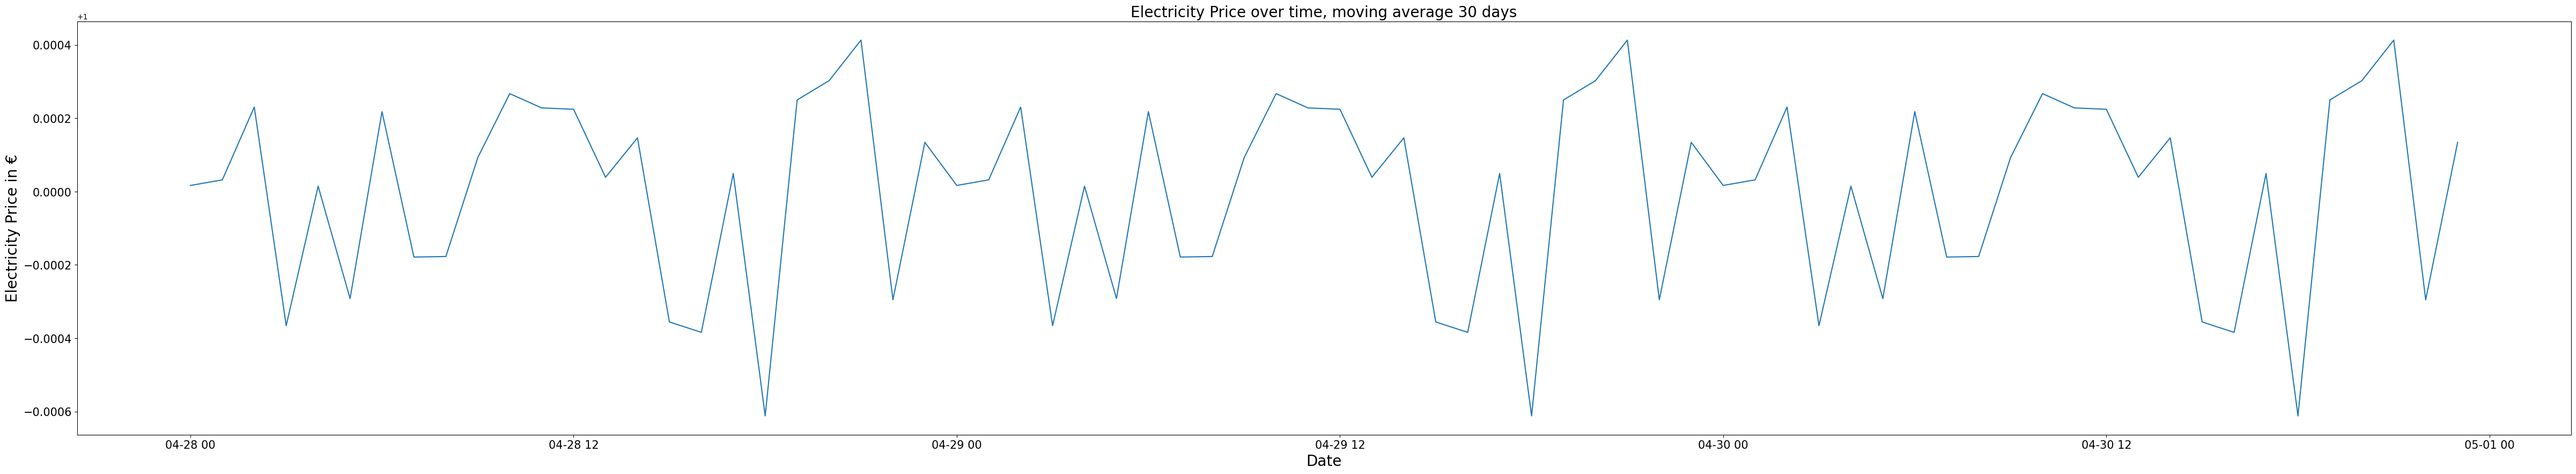

In [85]:
plt.figure(figsize=(60,10))
sns.lineplot(x=seasonality_.index, y=seasonality_)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Electricity Price in €', fontsize=20)
plt.title('Electricity Price over time, moving average 30 days', fontsize=20)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)


In [88]:
test = adfuller(df['Price'].loc['2019-05-30 00':'2020-04-30 23'])
print(f'Test Stat: {test[0]}')
print(f'p-value: {test[1]}')

Test Stat: -25.35405758291622
p-value: 0.0


In [72]:
result.seasonal

Date
2019-05-02 12:00:00+00:00    1.032691
2019-05-02 13:00:00+00:00    1.041932
2019-05-02 14:00:00+00:00    1.058679
2019-05-02 15:00:00+00:00    1.070450
2019-05-02 16:00:00+00:00    1.080022
                               ...   
2020-04-30 19:00:00+00:00    0.995507
2020-04-30 20:00:00+00:00    0.995088
2020-04-30 21:00:00+00:00    0.989383
2020-04-30 22:00:00+00:00    0.977152
2020-04-30 23:00:00+00:00    0.968445
Name: seasonal, Length: 8748, dtype: float64

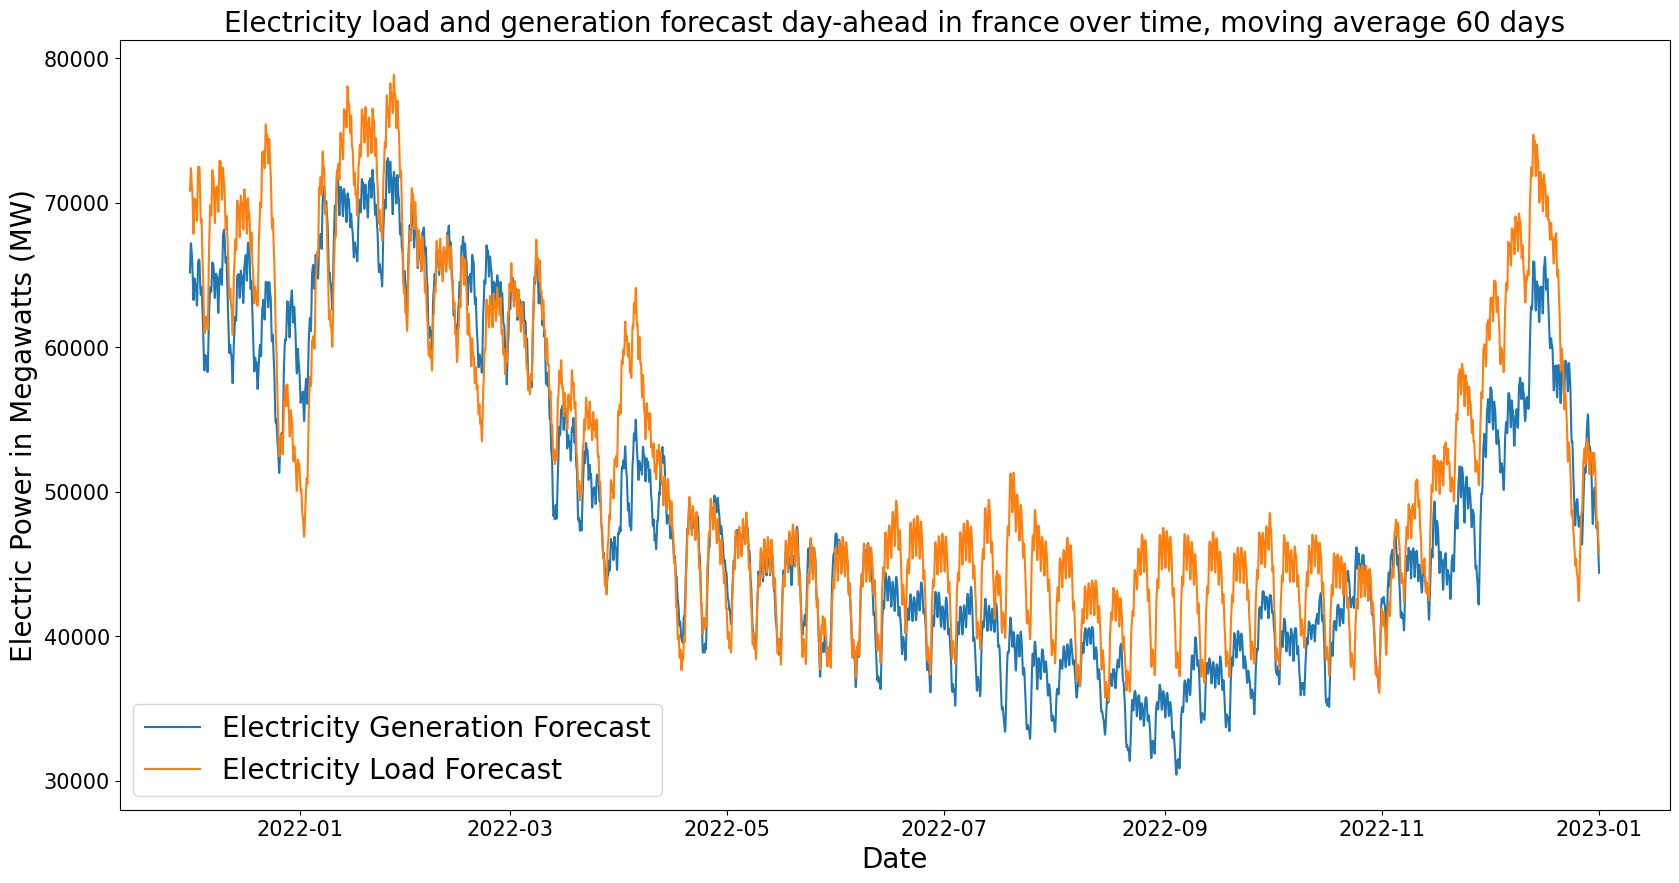

In [121]:
# Generate some time-series data
#dates = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
#data = pd.DataFrame(data={'Date': dates, 'Value': range(len(dates))})
df=df_all.loc['2021-11-30 00':'2022-12-31 23'].rolling(30).mean()#.diff().diff(24)
# Plot the data
plt.figure(figsize=(20,10))
sns.lineplot(x=df.index, y= 'Generation forecast', data=df, label='Electricity Generation Forecast')
sns.lineplot(x=df.index, y= 'Load forecast', data=df, label='Electricity Load Forecast')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Electric Power in Megawatts (MW)', fontsize=20)
plt.legend(fontsize=20)
plt.title('Electricity load and generation forecast day-ahead in france over time, moving average 60 days', fontsize=20)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('/Users/dorianfitton/Documents/Cours_Télécom/fil_rouge/fil_rouge.nosync/Rapport/images/LP_GP_MA_30.png')
plt.show()

<AxesSubplot:>

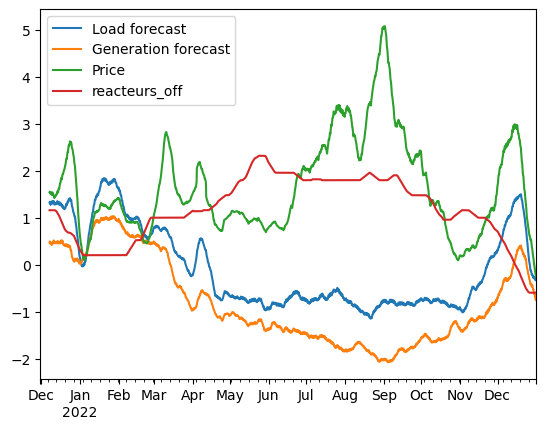

In [102]:
df_all.loc['2021-11-30 00':'2022-12-31 23'].rolling(180).mean().plot()